# UV to XY interpolation

## Aim of the notebook: to demonstrate how to perform UV to XY interpolation for image distortion using shaders.

**Unity** In shaders we typically have:

- UV coordinates: (u, v) ranging from 0 to 1, representing normalized texture coordinates.
- Apply distortion to create a distorted grid
- Sample the original image using the distorted coordinates

**In this notebook** We create a distorted output by looking up where each output pixel should come from in the input image

In [398]:
#Importing of libraries for data analysis

import matplotlib
import pandas as pd
import numpy as np
import scipy as sp
from scipy import interpolate
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

## 1. Core interpolation function

### Direct Forward-Mapping Approach (Like GPU Shaders)

For each output pixel:
1. Calculate its UV coordinate (0 to 1)
2. Apply distortion function to get distorted UV
3. Sample input image at distorted UV

### Inputs

- img: original image (numpy array)
- distortion_function: function that takes (u, v) and returns (distorted_u, distorted_v)
- output_resolution: (height, width) for output image

### Outputs

- Distorted image

In [399]:
def uv_to_xy_interpolation(img, distortion_function=None, output_resolution=None):
    """
    Perform direct forward-mapping image distortion (like GPU shaders).
    
    For each output pixel:
    1. Calculate UV coordinate (0 to 1)
    2. Apply distortion to UV
    3. Sample input at distorted UV
    
    Parameters:
        img (numpy array): Input image as a numpy array.
        distortion_function (callable): Function that takes (u, v) and returns (distorted_u, distorted_v)
        output_resolution: (height, width) for output image
    """
    
    output_height, output_width = output_resolution
    
    # Create output UV grid (0 to 1)
    u_coords = np.linspace(0, 1, output_width)
    v_coords = np.linspace(0, 1, output_height)
    u_grid, v_grid = np.meshgrid(u_coords, v_coords)
    
    # Apply distortion to each UV coordinate
    if distortion_function is not None:
        shape = u_grid.shape
        u_flat = u_grid.flatten()
        v_flat = v_grid.flatten()
        
        # Apply distortion to each point
        distorted_points = np.array([distortion_function(u, v) for u, v in zip(u_flat, v_flat)])
        
        distorted_u = distorted_points[:, 0].reshape(shape)
        distorted_v = distorted_points[:, 1].reshape(shape)
    else: # No distortion case
        distorted_u = u_grid
        distorted_v = v_grid
    
    # Convert distorted UV to pixel coordinates in the input image
    pixel_x = distorted_u * (img.shape[1] - 1)
    pixel_y = distorted_v * (img.shape[0] - 1)
    
    # Sample from input image using map_coordinates
    if len(img.shape) == 2:  # If it is a grayscale image
        distorted_img = map_coordinates(img, [pixel_y, pixel_x], order=1, mode='constant', cval=0.0)
    else:  # If it is a color image
        channels = []
        for c in range(img.shape[2]):
            channel = map_coordinates(img[:, :, c], [pixel_y, pixel_x], order=1, mode='constant', cval=0.0)
            channels.append(channel)
        distorted_img = np.stack(channels, axis=-1)
    
    return distorted_img

## 2. Aid function: creation of regular grid from points -> Used for the core interpolation function

# Create regular grid df from defined points

### Inputs

- grid_resolution: Resolution of the grid, originally defined for the dimensions of an Amsler Grid (8x8)

### Outputs

- grid_df: DataFrame for the regular grid that can posteriously be plotted

In [400]:
def grid_nodistortion(grid_resolution=(8,8)):
    rows, cols = grid_resolution
    uv_x = np.linspace(0, 1, cols)
    uv_y = np.linspace(0, 1, rows)
    uv_grid_x, uv_grid_y = np.meshgrid(uv_x, uv_y)

    # Flatten the grid for DataFrame creation
    uv_x_flat = uv_grid_x.flatten()
    uv_y_flat = uv_grid_y.flatten()

    # Create DataFrame
    grid_df = pd.DataFrame({'uv_x': uv_x_flat, 'uv_y': uv_y_flat, 'x': uv_x_flat, 'y': uv_y_flat})

    return grid_df

## 3. Aid function: creation of distorted grid from points -> Used for the core interpolation function

### Creates distorted grid df from control points -> User defines how specific UV positions map to distorted XY positions

### Inputs

- grid_resolution: (rows, cols)
- distortion_function: function that takes (uv_x, uv_y) and returns (distorted_x, distorted_y)

### Outputs

- df with columns ['uv_x', 'uv_y', 'distorted_x', 'distorted_y']

In [401]:
def create_distorted_grid(grid_resolution=(10, 10), distortion_function = None):
    rows, cols = grid_resolution

    # Create UV grid

    uv_x = np.linspace(0, 1, cols)
    uv_y = np.linspace(0, 1, rows)
    uv_grid_x, uv_grid_y = np.meshgrid(uv_x, uv_y)

    # Flatten for df

    uv_x_flat = uv_grid_x.flatten()
    uv_y_flat = uv_grid_y.flatten()

    # Apply distortion
    if distortion_function is None:
        distorted_points = np.stack([uv_x_flat, uv_y_flat], axis=1)  # No distortion
    else:
        distorted_points = np.array([distortion_function(u, v) for u, v in zip(uv_x_flat, uv_y_flat)])

    # Create dataframe for storage of values

    grid_df = pd.DataFrame({'uv_x': uv_x_flat, 'uv_y': uv_y_flat, 'distorted_x': distorted_points[:, 0], 'distorted_y': distorted_points[:, 1]})

    return grid_df

## 4. Exemplar distortion function: barrel distortion

### Applies a barrel distortion to specific UV coordinates


In [402]:
def barrel_distortion(u, v):
    cx, cy = 0.5, 0.5  # Center of the distortion
    dx, dy = u - cx, v - cy
    r = np.sqrt(dx**2 + dy**2)
    k = 4.0 # Distortion coefficient
    r_distorted = r * (1 + k * r**2)
    if r > 0:
        scale = r_distorted/r
        return cx + dx * scale, cy + dy * scale
    else:
        return cx, cy

## 5. Grids plotting

### Performs a overlapped plotting of the regular grid and the distorted grid for comparison purposes

In [403]:
def plot_grids(original_grid_df, distorted_grid_df):
    plt.figure(figsize = (8,8))
    plt.scatter(original_grid_df['uv_x'], original_grid_df['uv_y'], color='blue', label='Original Grid')
    plt.scatter(distorted_grid_df['distorted_x'], distorted_grid_df['distorted_y'], color='red', label='Distorted Grid')
    plt.title('Regular grid vs. Distorted grid')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.axis('equal')
    plt.grid(alpha = 0.3)
    plt.show()

## Images plotting

### Performs a comparative plotting of the original image and the distorted image side by side

In [404]:
def plot_images(original_img, distorted_img):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(distorted_image)
    axes[1].set_title('Distorted Image')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

## Limit computation

### Determines the limits for the comparative grid and image representations

In [405]:
def determine_limits(original_df, distorted_df):
    # Get bounds of the original grid
    original_bounds = (0.0, 1.0, 0.0, 1.0) # (min_x, max_x, min_y, max_y)

    # Get bounds of the distorted grid
    distorted_x = distorted_df['distorted_x'].values
    distorted_y = distorted_df['distorted_y'].values
    distorted_bounds = distorted_x.min(), distorted_x.max(), distorted_y.min(), distorted_y.max()

    #Find intersecting/overlapping region

    x_min = max(original_bounds[0], distorted_bounds[0])
    x_max = min(original_bounds[1], distorted_bounds[1])
    y_min = max(original_bounds[2], distorted_bounds[2])
    y_max = min(original_bounds[3], distorted_bounds[3])

    return (x_min, x_max, y_min, y_max)

## Restricted plotting

### Plots the grid and images according to the defined limits of the grid

In [406]:
def restricted_grid_plotting(original_grid_df, distorted_grid_df, zoom_x, zoom_y):
    plt.figure(figsize=(8, 8))

    # Filter original grid points to only those within the zoom region
    original_mask = (
        (original_grid_df['uv_x'] >= zoom_x[0]) &
        (original_grid_df['uv_x'] <= zoom_x[1]) &
        (original_grid_df['uv_y'] >= zoom_y[0]) &
        (original_grid_df['uv_y'] <= zoom_y[1])
    )
    original_filtered = original_grid_df[original_mask]

    # Filter distorted grid points to only those within the zoom region
    distorted_mask = (
        (distorted_grid_df['distorted_x'] >= zoom_x[0]) &
        (distorted_grid_df['distorted_x'] <= zoom_x[1]) &
        (distorted_grid_df['distorted_y'] >= zoom_y[0]) &
        (distorted_grid_df['distorted_y'] <= zoom_y[1])
    )
    distorted_filtered = distorted_grid_df[distorted_mask]

    # Plot only filtered grid points
    plt.scatter(original_filtered['uv_x'], original_filtered['uv_y'],
               color='blue', label='Original Grid', s=50)
    plt.scatter(distorted_filtered['distorted_x'], distorted_filtered['distorted_y'],
               color='red', label='Distorted Grid', s=50)

    # Apply zoom limits
    plt.xlim(zoom_x)
    plt.ylim(zoom_y)
    plt.title('Zoomed to Overlapping Region')
    plt.xlabel('U')
    plt.ylabel('V')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [407]:
def restricted_image_plotting(original_img, distorted_img, zoom_x, zoom_y):

    # Convert normalized coordinates to pixel coordinates for cropping
    img_height, img_width = original_img.shape[:2]
    
    x_min_px = int(zoom_x[0] * img_width)
    x_max_px = int(zoom_x[1] * img_width)
    y_min_px = int(zoom_y[0] * img_height)
    y_max_px = int(zoom_y[1] * img_height)
    
    # Crop both images to the restricted region
    original_crop = original_img[y_min_px:y_max_px, x_min_px:x_max_px]
    distorted_crop = distorted_img[y_min_px:y_max_px, x_min_px:x_max_px]
    
    # Perform blending on the cropped images
    blended_crop = 0.5 * original_crop + 0.5 * distorted_crop
    blended_crop = np.clip(blended_crop, 0, 1)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Define extent for the cropped region [left, right, bottom, top]
    extent_restricted = [zoom_x[0], zoom_x[1], zoom_y[1], zoom_y[0]]
    
    # Display ONLY the blended cropped image
    im = ax.imshow(blended_crop, extent=extent_restricted, origin='upper', interpolation='nearest')
    
    # Use get_extent() to retrieve the actual extent
    actual_extent = im.get_extent()
    
    # Set axis limits to exactly match the extent
    ax.set_xlim(actual_extent[0], actual_extent[1])
    ax.set_ylim(actual_extent[2], actual_extent[3])
    
    # Define plotting labels and title
    ax.set_title('Overlapped Images - Restricted Region Only')
    ax.set_xlabel('U')
    ax.set_ylabel('V')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## Main workflow

### For the execution of the procedure of grid generation, deformation and plotting

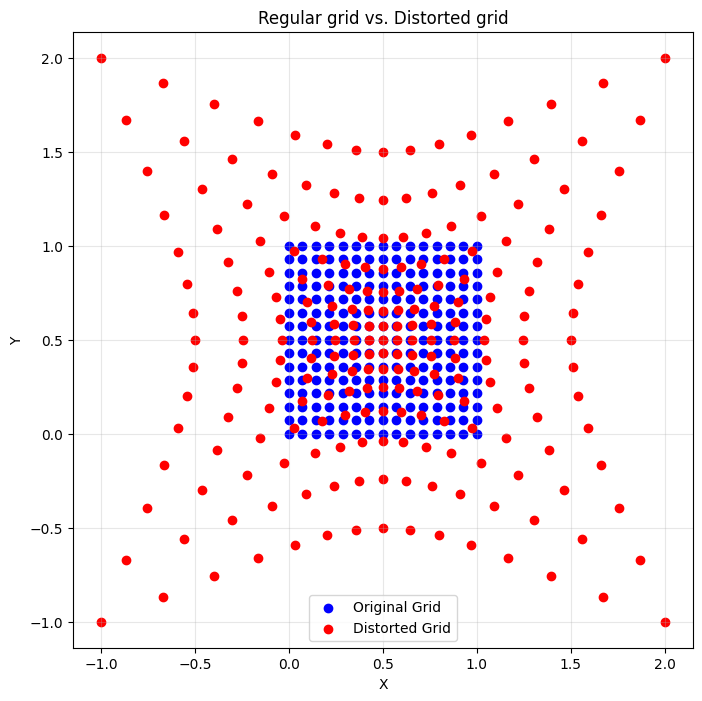

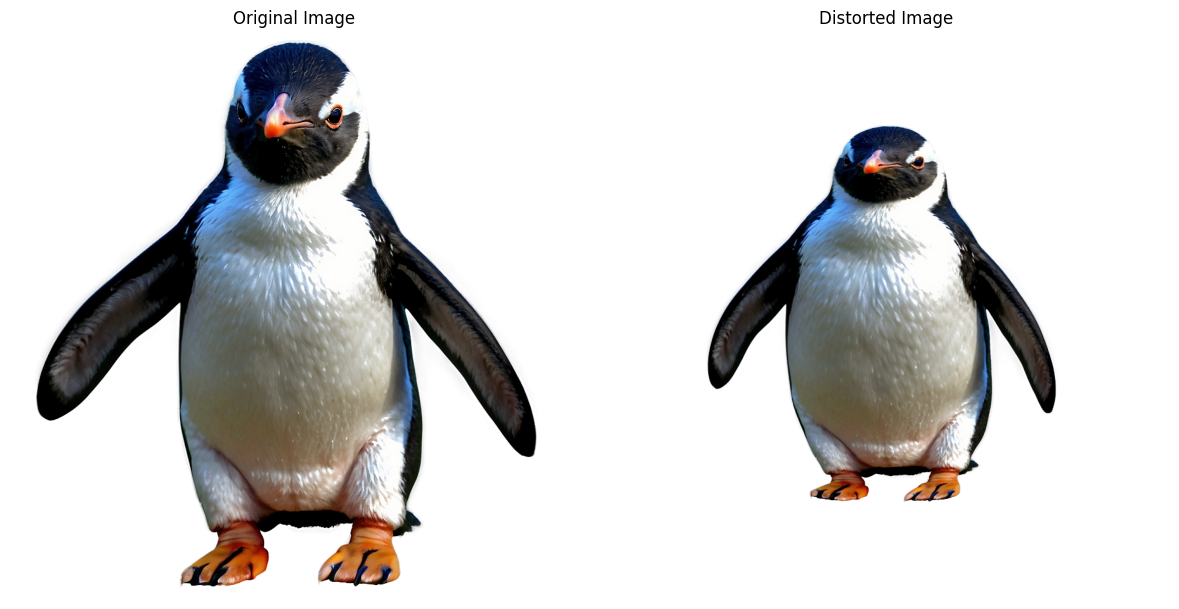

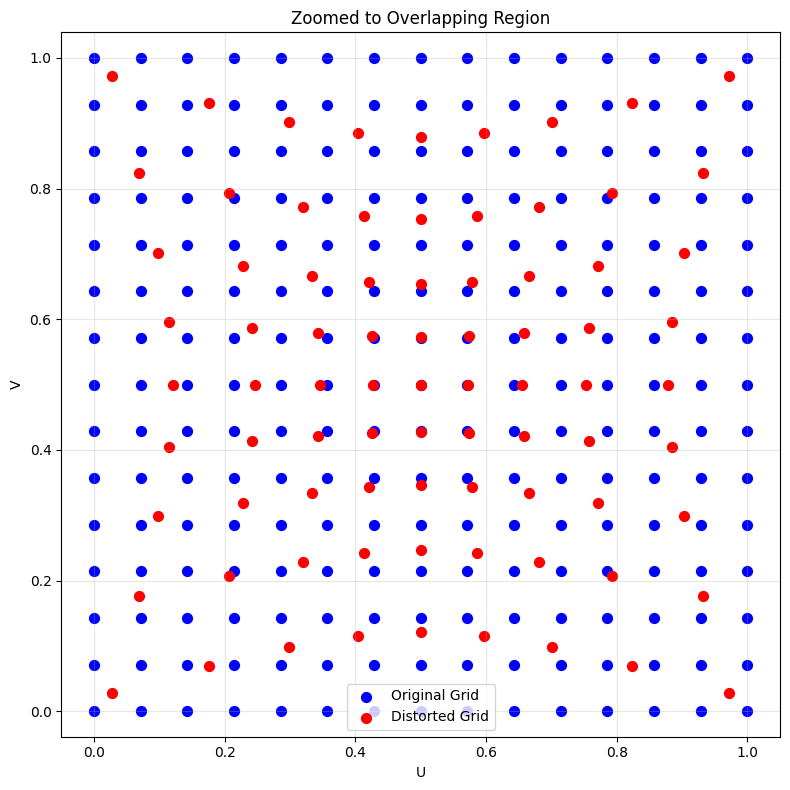

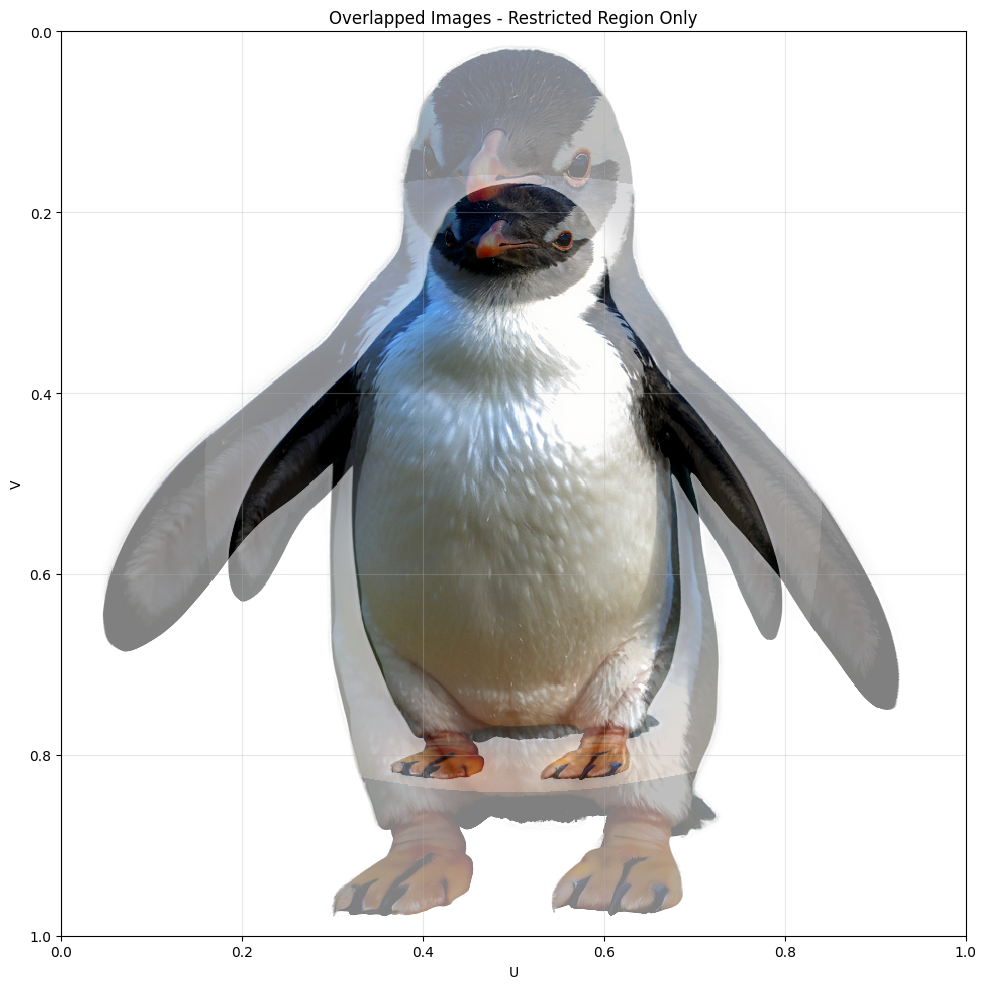

In [408]:
# Loading of image

image_path = 'C:/Users/SoniaP/Documents/ZVSL_VR/AmslerGrid_VRApp/Shaders_test/Penguin.png'
original_image = np.array(Image.open(image_path))

if original_image.dtype == np.uint8:
    original_image = original_image.astype(np.float32) / 255.0

# Definition of grid resolution for visualization

grid_resolution = (15, 15)  # Using lower resolution for clearer grid visualization

# Creation of regular grid for visualization

regular_grid_df = grid_nodistortion(grid_resolution = grid_resolution)

# Creation of distorted grid for visualization

distorted_grid_df = create_distorted_grid(grid_resolution = grid_resolution, distortion_function = barrel_distortion)

# Plotting of grids to visualize distortion pattern

plot_grids(regular_grid_df, distorted_grid_df)

# Interpolation to create distorted image using direct forward mapping

output_resolution = (original_image.shape[0], original_image.shape[1])
distorted_image = uv_to_xy_interpolation(img = original_image, distortion_function = barrel_distortion, output_resolution = output_resolution)

# Plotting of images

plot_images(original_image, distorted_image)

# Calculation of limits

limits = determine_limits(regular_grid_df, distorted_grid_df)
zoom_x = (limits[0], limits[1])
zoom_y = (limits[2], limits[3])

# Plotting of restricted views
restricted_grid_plotting(regular_grid_df, distorted_grid_df, zoom_x, zoom_y)
restricted_image_plotting(original_image, distorted_image, zoom_x, zoom_y)